### Introduction:

The Myers-Briggs Type Indicator is an introspective self-report questionaire with the purpose 
of indication differeing psychological preferences in how people perceive the world around them and make decisions. 

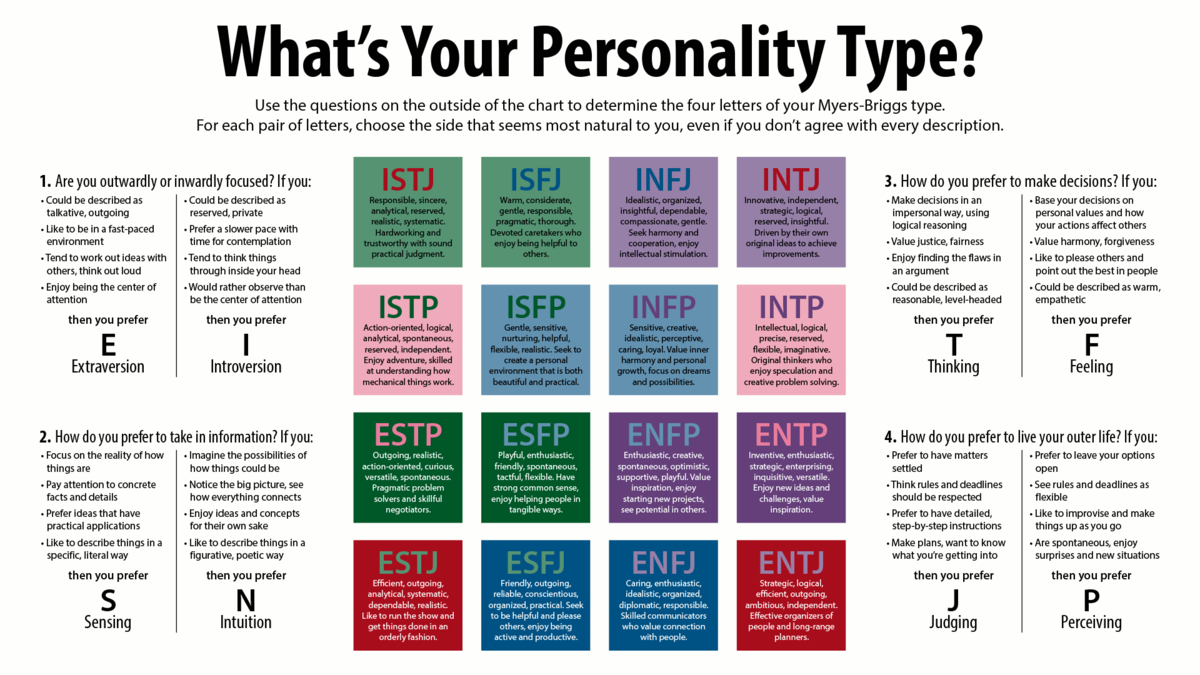

In [3]:
from IPython.display import Image
Image("/Users/emma/Desktop/MBTI.png")

### Step one：
Import packages

In [4]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from bs4 import BeautifulSoup
py.init_notebook_mode(connected=True)

### Step two: 
Load MBTI data set and do exploration. 

In [5]:
train = pd.read_csv('/Users/emma/Dropbox (School of Management)/MSBA/all courses/第二学期/452machinelearning/pre/mbti_1.csv')

This dataset contains over 8600 rows of data, on each row is a person’s:
Type (This persons 4 letter MBTI code/type)
A section of each of the last 50 things they have posted (Each entry separated by "|||" (3 pipe characters))

In [6]:
train.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


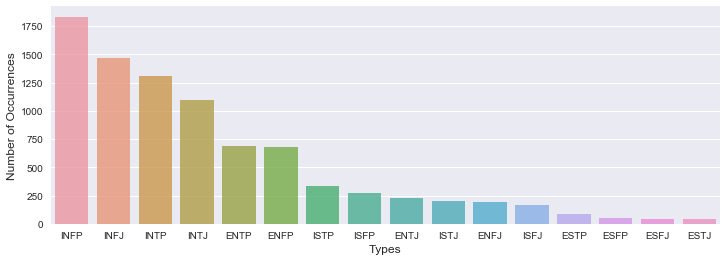

In [7]:
cnt_srs = train['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

In [8]:
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)

train['word_per_comment'] = train['posts'].apply(lambda x: len(x.split())/50)
train['variance_of_word_counts'] = train['posts'].apply(lambda x:var_row(x))

In [9]:
train.head()

,type,posts,word_per_comment,variance_of_word_counts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.2900
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.4756
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.6900
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.8324
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.4576


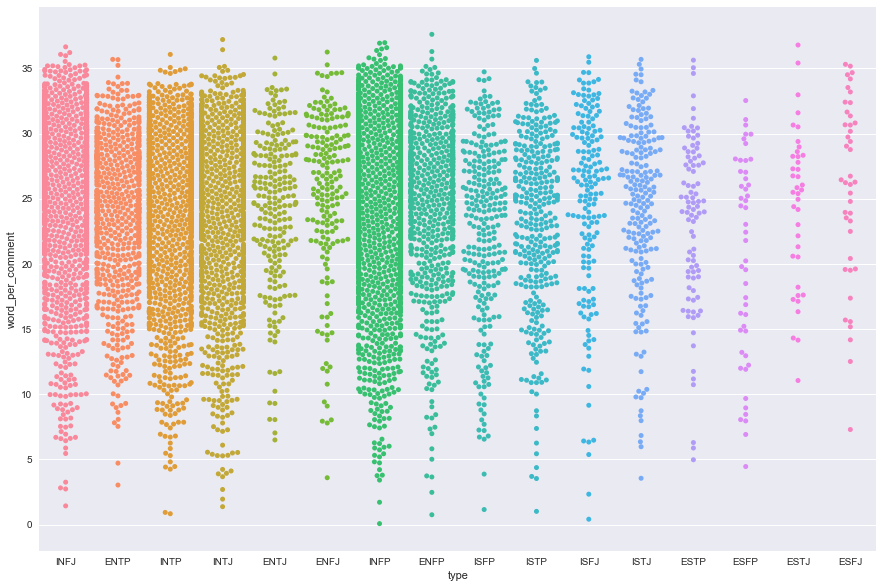

In [10]:
plt.figure(figsize=(15,10))
sns.swarmplot("type", "word_per_comment", data=train)

!!INFPs have a talent for self-expression, revealing their beauty and their secrets through metaphors and fictional characters.

!!There’s nothing that makes ESFPs feel quite as unhappy as realizing that
they are boxed in by circumstance, unable to join their friends.

In [11]:
train.groupby('type').agg({"type":"count"})

,type
type,
ENFJ,190
ENFP,675
ENTJ,231
ENTP,685
ESFJ,42
ESFP,48
ESTJ,39
ESTP,89
INFJ,1470


In [12]:
train_2 = train[~train['type'].isin(['ESFJ','ESFP','ESTJ','ESTP'])]
train_2['http_per_comment'] = train_2['posts'].apply(lambda x: x.count('http')/50)
train_2['qm_per_comment'] = train_2['posts'].apply(lambda x:x.count('?')/50)
train_2.head()

/Users/emma/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/emma/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,type,posts,word_per_comment,variance_of_word_counts,http_per_comment,qm_per_comment
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.2900,0.48,0.36
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.4756,0.20,0.10
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.6900,0.10,0.24
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.8324,0.04,0.22
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.4576,0.12,0.20


In [13]:
print(train_2.groupby('type').agg({'http_per_comment': 'mean'}))
print(train_2.groupby('type').agg({'qm_per_comment': 'mean'}))

      http_per_comment
type                  
ENFJ          0.053263
ENFP          0.050459
ENTJ          0.053160
ENTP          0.048263
INFJ          0.065878
INFP          0.075426
INTJ          0.063593
INTP          0.070767
ISFJ          0.070602
ISFP          0.088339
ISTJ          0.061171
ISTP          0.081009
      qm_per_comment
type                
ENFJ        0.213053
ENFP        0.227259
ENTJ        0.240000
ENTP        0.220964
INFJ        0.208966
INFP        0.202533
INTJ        0.214849
INTP        0.221580
ISFJ        0.200964
ISFP        0.216384
ISTJ        0.214927
ISTP        0.221602


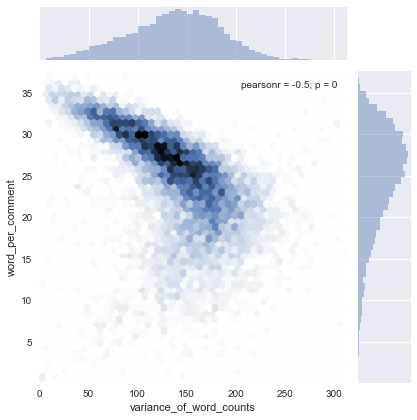

In [14]:
plt.figure(figsize=(15,10))
sns.jointplot("variance_of_word_counts", "word_per_comment", data=train_2, kind="hex")

## The pearsonr correlation index is -0.5, which mean people who give long comments are alwasy turn to give long comments, which could because of their habits or characters. 

### Step three: 
## Logistic Regression

In [16]:
train_0 = pd.read_csv('/Users/emma/Dropbox (School of Management)/MSBA/all courses/第二学期/452machinelearning/pre/mbti_1.csv')

In [17]:
us = pd.read_csv('/Users/emma/Dropbox (School of Management)/MSBA/all courses/第二学期/452machinelearning/pre/Users.csv')
ps = pd.read_csv('/Users/emma/Dropbox (School of Management)/MSBA/all courses/第二学期/452machinelearning/pre/ForumMessages.csv')

In [18]:
mbti = {'I':'Introversion', 'E':'Extroversion', 'N':'Intuition', 
        'S':'Sensing', 'T':'Thinking', 'F': 'Feeling', 
        'J':'Judging', 'P': 'Perceiving'}

In [19]:
train_0.shape

(8675, 2)

In [20]:
ps['Message'] = ps['Message'].fillna('')

In [21]:
ps_join = ps.groupby('AuthorUserId')['Message'].agg(lambda col: ' '.join(col)).reset_index()

In [22]:
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    return text

In [23]:
train_0['clean_posts'] = train_0['posts'].apply(cleanText)

In [24]:
np.random.seed(1)

tfidf2 = CountVectorizer(ngram_range=(1, 1), stop_words='english',
                                                 lowercase = True, max_features = 5000)

model_lr = Pipeline([('tfidf1', tfidf2), ('lr', LogisticRegression(class_weight="balanced", C=0.005))])

results_lr = cross_val_score(model_lr, train_0['clean_posts'], train_0['type'], n_jobs=-1)

## My jupternotebook can not import cross_validate, so I use cross_val_score.

In [25]:
ps_join['clean_comments'] = ps_join['Message'].apply(cleanText)

In [26]:
model_lr.fit(train_0['clean_posts'], train_0['type'])
pred_all = model_lr.predict(ps_join['clean_comments'])

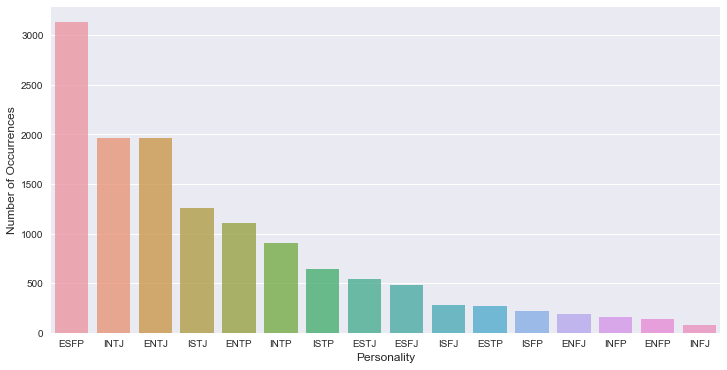

In [27]:
cnt_all = np.unique(pred_all, return_counts=True)

pred_df = pd.DataFrame({'personality': cnt_all[0], 'count': cnt_all[1]},
                      columns=['personality', 'count'], index=None)

pred_df.sort_values('count', ascending=False, inplace=True)

plt.figure(figsize=(12,6))
sns.barplot(pred_df['personality'], pred_df['count'], alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Personality', fontsize=12)
plt.show()

In [28]:
pred_df['percent'] = pred_df['count']/pred_df['count'].sum()

In [29]:
pred_df['description'] = pred_df['personality'].apply(lambda x: ' '.join([mbti[l] for l in list(x)]))

In [30]:
pred_df

,personality,count,percent,description
5,ESFP,3132,0.234783,Extroversion Sensing Feeling Perceiving
10,INTJ,1967,0.147451,Introversion Intuition Thinking Judging
2,ENTJ,1966,0.147376,Extroversion Intuition Thinking Judging
14,ISTJ,1255,0.094078,Introversion Sensing Thinking Judging
3,ENTP,1105,0.082834,Extroversion Intuition Thinking Perceiving
11,INTP,909,0.068141,Introversion Intuition Thinking Perceiving
15,ISTP,642,0.048126,Introversion Sensing Thinking Perceiving
6,ESTJ,546,0.040930,Extroversion Sensing Thinking Judging
4,ESFJ,480,0.035982,Extroversion Sensing Feeling Judging
12,ISFJ,281,0.021064,Introversion Sensing Feeling Judging


In [31]:
labels = pred_df['description']
sizes = pred_df['percent']*100

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Kaggle Personality Distribution')
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

The most common Kaggle users personality is ESFP (Extroversion Sensing Feeling Perceiving), but we are getting this conclusion based on users comments: it is reasonable to think that users who participate more writting comments are more extrovert. 